Shape: (7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Categorical columns detected: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


/tmp/ipython-input-1176988720.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


Final feature matrix shape: (7043, 30)
Churn distribution:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Before SMOTE, train class distribution: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE, train class distribution: Churn
0    4139
1    4139
Name: count, dtype: int64
Accuracy: 0.7700

Classification Report:
              precision    recall  f1-score   support

           0     0.8455    0.8406    0.8430      1035
           1     0.5658    0.5749    0.5703       374

    accuracy                         0.7700      1409
   macro avg     0.7056    0.7077    0.7067      1409
weighted avg     0.7712    0.7700    0.7706      1409

Confusion Matrix:
 [[870 165]
 [159 215]]
ROC-AUC: 0.8199


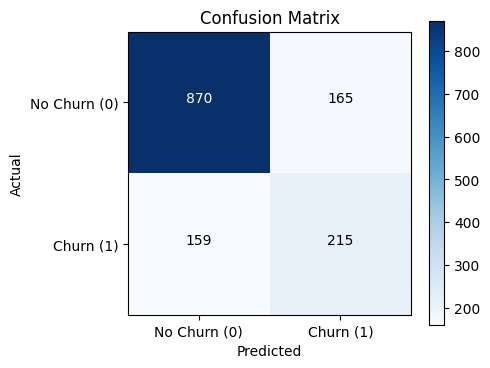

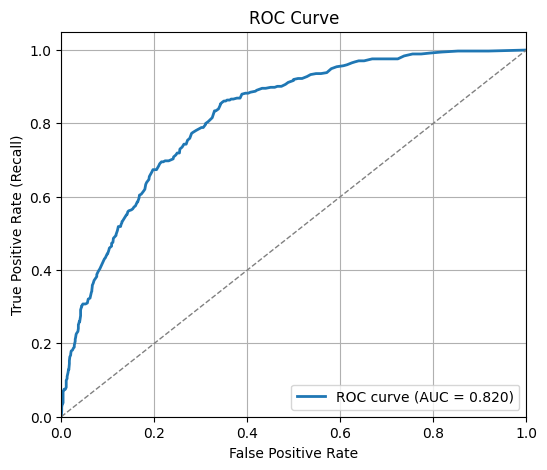

Top 15 feature importances:
TotalCharges                      0.163271
tenure                            0.149742
MonthlyCharges                    0.131921
PaymentMethod_Electronic check    0.100706
InternetService_Fiber optic       0.054236
PaperlessBilling                  0.049087
Dependents                        0.038026
Contract_Two year                 0.034872
MultipleLines_Yes                 0.022111
gender                            0.021437
Partner                           0.020337
Contract_One year                 0.018760
StreamingTV_Yes                   0.017557
StreamingMovies_Yes               0.017414
OnlineBackup_Yes                  0.016808
dtype: float64
Model and scaler saved to disk (rf_churn_model.joblib, scaler_for_churn.joblib)


In [4]:
# churn_pipeline.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# ---- Load ----
path = "/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv"  # update if needed
df = pd.read_csv(path)

# ---- Basic Inspection (optional) ----
print("Shape:", df.shape)
print(df.columns.tolist()[:40])
# print(df.head())

# ---- Clean / Typical Telco fixes ----
# Drop customerID if present
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)

# Fix TotalCharges if present (some versions have spaces which are read as strings)
if "TotalCharges" in df.columns:
    # Empty strings -> NaN -> convert to numeric
    df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    # Fill NaN (if any) with 0 or median — choose median here
    df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# ---- Target processing ----
# Standard Telco dataset uses 'Churn' with values 'Yes'/'No'
if df["Churn"].dtype == object:
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
# If it's already numeric (0/1) this will leave as is

# ---- Handle missing values (simple strategy) ----
# For numeric columns, fill with median; for object columns fill with mode
for col in df.columns:
    if df[col].isna().any():
        if df[col].dtype in [np.float64, np.int64]:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

# ---- Categorical encoding (auto) ----
# - Binary categorical -> map to 0/1
# - Multiclass categorical -> get_dummies (one-hot) with drop_first=True
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns detected:", cat_cols)

for col in cat_cols:
    uniq = df[col].nunique()
    if uniq == 2:
        # map two categories to 0/1
        vals = df[col].unique().tolist()
        mapping = {vals[0]: 0, vals[1]: 1}
        df[col] = df[col].map(mapping)
    else:
        # one-hot encode
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

# ---- Final features & target ----
if "Churn" not in df.columns:
    raise ValueError("Target column 'Churn' not found after preprocessing.")

X = df.drop("Churn", axis=1)
y = df["Churn"]

print("Final feature matrix shape:", X.shape)
print("Churn distribution:\n", y.value_counts(normalize=True))

# ---- Train-test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Handle imbalance using SMOTE on training set only ----
print("Before SMOTE, train class distribution:", y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE, train class distribution:", pd.Series(y_train_sm).value_counts())

# ---- Scale features (fit on training only) ----
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# ---- Train model ----
model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
model.fit(X_train_sm, y_train_sm)

# ---- Predictions & Probabilities ----
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# ---- Evaluation ----
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ["No Churn (0)", "Churn (1)"])
plt.yticks(tick_marks, ["No Churn (0)", "Churn (1)"])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# ---- Plot ROC Curve ----
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---- Feature importance (top 15) ----
feat_names = X.columns
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("Top 15 feature importances:")
print(feat_importance.head(15))

# ---- Save the model and scaler ----
joblib.dump(model, "rf_churn_model.joblib")
joblib.dump(scaler, "scaler_for_churn.joblib")
print("Model and scaler saved to disk (rf_churn_model.joblib, scaler_for_churn.joblib)")

